# Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

We will
* Implement the LSH algorithm for approximate nearest neighbor search
* Examine the accuracy for different documents by comparing against brute force search, and also contrast runtimes
* Explore the role of the algorithm’s tuning parameters in the accuracy of the method

## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

### compute norm of a sparse vector

In [2]:
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

## Load in the Wikipedia dataset

In [3]:
wiki = pd.read_csv('A:/PROGRAMMING/LSH/people_wiki.csv')

In [4]:
print("%s rows and %s columns"%wiki.shape)
print("Columns: ", list(wiki.columns.values))
wiki[:3]

59071 rows and 3 columns
Columns:  ['URI', 'name', 'text']


,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...


## Extract TF-IDF matrix

We first use scikit tf-idf vectorizer to compute a TF-DF representation for each document.

In [5]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
start = time.time()
vect = TfidfVectorizer(sublinear_tf=True, analyzer='word',stop_words='english')
vect = vect.fit(wiki.text)
feature_mappings = vect.get_feature_names()
stop_words = vect.get_stop_words()
print('Stop words:\n',stop_words,'\n')
vect = vect.transform(wiki.text)
print('--- %s seconds ---' % (time.time()-start))
print('Shape of the sparsed matrix', vect.shape)

Stop words:
 frozenset({'only', 'get', 'now', 'ltd', 'put', 'eleven', 'same', 'see', 'twenty', 'fifteen', 'no', 'onto', 'we', 'interest', 'ie', 'sincere', 'twelve', 'what', 'empty', 'from', 'of', 'so', 'beforehand', 'several', 'after', 'all', 'by', 'sometime', 'above', 'still', 'although', 'towards', 'on', 'third', 'who', 'itself', 'thereafter', 'five', 'amoungst', 'across', 'sometimes', 'therefore', 'such', 'whole', 'everything', 'against', 'those', 'when', 'around', 'everyone', 'nothing', 'became', 'whereby', 'four', 'three', 'upon', 'toward', 'up', 'etc', 'further', 'becomes', 'forty', 'one', 'very', 'should', 'both', 'if', 'describe', 'inc', 'thence', 'whereupon', 'neither', 'anyway', 'during', 'back', 'since', 'though', 'together', 'whatever', 'wherever', 'sixty', 'will', 'become', 'eg', 'latter', 'ourselves', 'name', 'them', 'system', 'noone', 'front', 'none', 'ours', 'eight', 'off', 'beside', 'more', 'nor', 'becoming', 'into', 'whenever', 'top', 'amount', 'yours', 'please', 'you

From now we will use sparse matrices. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.
We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format.

In [6]:
print("Words from the text which serve as features:\n",feature_mappings[400001:400010])
print(vect[:,1][:2000,:])
print("Row 424, column 1: ", vect[424, 1])
print("Row 12, column 1:", vect[12,1])

Words from the text which serve as features:
 ['propuestas', 'propulsidon', 'propulsion', 'propulsive', 'proputin', 'propvisagie', 'propylene', 'proqaddafi', 'proquest']
  (424, 0)	0.0790540548468
  (1052, 0)	0.0457446808866
  (1572, 0)	0.182725791271
Row 424, column 1:  0.0790540548468
Row 12, column 1: 0.0


In [7]:
print(type(vect))
print(type(vect[:,1]))
print(type(vect[1,:]))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [8]:
print(vect.shape)

(59071, 548116)


## Train LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. We will implement method of LSH known as random binary projection, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.
The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [9]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions.  Below, we generate 3 random vectors each of dimension 5.

In [10]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
generate_random_vectors(num_vector=3, dim=5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

We now generate random vectors of the same dimensionality as our vocubulary size (548116).  Each vector can be used to compute one bit in the bin encoding.  We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [11]:
# Generate 16 random vectors of dimension 548116
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=vect.shape[1])
random_vectors.shape

(548116, 16)

Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [12]:
doc = vect[0, :] # vector of tf-idf values for document 0
doc.dot(random_vectors[:, 0]) >= 0 # True if positive sign; False if negative sign

array([False], dtype=bool)

Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector.

In [13]:
doc.dot(random_vectors[:, 1]) >= 0 # True if positive sign; False if negative sign

array([False], dtype=bool)

We can compute all of the bin index bits at once as follows. Note the absence of the explicit `for` loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the `for` loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater.

In [14]:
doc.dot(random_vectors) >= 0 # should return an array of 16 True/False bits

array([[False, False, False,  True,  True, False,  True, False, False,
        False, False,  True, False, False,  True, False]], dtype=bool)

In [15]:
np.array(doc.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

array([[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations  so that no explicit loop is needed.

In [16]:
vect[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents

array([[False, False, False,  True,  True, False,  True, False, False,
        False, False,  True, False, False,  True, False],
       [False,  True, False, False, False, False, False,  True,  True,
        False,  True, False, False, False, False, False]], dtype=bool)

In [17]:
vect.dot(random_vectors) >= 0 # compute bit indices of ALL documents

array([[False, False, False, ..., False,  True, False],
       [False,  True, False, ..., False, False, False],
       [False,  True,  True, ..., False, False,  True],
       ..., 
       [False,  True,  True, ..., False,  True, False],
       [ True,  True, False, ..., False, False, False],
       [ True, False, False, ...,  True,  True,  True]], dtype=bool)

We're almost done! To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```
By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [18]:
doc = vect[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (index_bits)
print (powers_of_two)
print (index_bits.dot(powers_of_two))

[[False False False  True  True False  True False False False False  True
  False False  True False]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[6674]


Since it's the dot product again, we batch it with a matrix operation:

In [19]:
index_bits = vect.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([ 6674, 16800, 27153, ..., 24962, 51760, 37663], dtype=int32)

This array gives us the integer index of the bins for all documents.

Given the integer bin indices for the documents, we will compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

In [20]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            table[bin_index] = list()
        newlist = table[bin_index]
        newlist.append(data_index)
        table[bin_index] = newlist

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}   
    return model

**Show**. 

In [21]:
model = train_lsh(vect, num_vector=16, seed=143)
table = model['table']
if   0 in table:
    print('0 : ',table[0])    
if 143 in table:
    print('143 : ',table[143])

0 :  [20650, 52969]


## Inspect bins

Let us look at some documents and see which bins they fall into.

In [22]:
wiki[wiki['name'] == 'Rihanna']

,URI,name,text
24857,<http://dbpedia.org/resource/Rihanna>,Rihanna,robyn rihanna fenty born february 20 1988 know...


In [23]:
wiki[wiki['name'] == 'Justin Timberlake']

,URI,name,text
33057,<http://dbpedia.org/resource/Justin_Timberlake>,Justin Timberlake,justin randall timberlake born january 31 1981...


In [24]:
rihannaix = int(wiki[wiki['name'] == 'Rihanna'].index.values)
for key in table:
    if rihannaix in table[key]:
        print('bin %s'%key)
        print(table[key])

bin 37308
[24857, 25790]


Let's see the same for Timberlake

In [25]:
timberlakeix = int(wiki[wiki['name'] == 'Justin Timberlake'].index.values)
for key in table:
    if timberlakeix in table[key]:
        print('bin %s'%key)
        print(table[key])

bin 20891
[31609, 33057]


Let's examine the bit representations of the bins containing Rihanna and Justin Timberlake, and see in how many places do they agree out of 16 (16 if they fall into one bin).

In [26]:
bin_index_bits = model['bin_index_bits']
rihanna_bits = bin_index_bits[rihannaix]
timberlake_bits = bin_index_bits[timberlakeix]

In [27]:
print(rihannaix)
print(timberlakeix)

24857
33057


In [28]:
print(rihanna_bits)
print(timberlake_bits)

[ True False False  True False False False  True  True False  True  True
  True  True False False]
[False  True False  True False False False  True  True False False  True
  True False  True  True]


In [29]:
print(rihanna_bits & timberlake_bits)
print("Number of common places: ",sum(rihanna_bits & timberlake_bits))

[False False False  True False False False  True  True False False  True
  True False False False]
Number of common places:  5


In [30]:
## how about somebody else:
vincentix = int(wiki[wiki['name'] == 'Jayanan Vincent'].index.values)
print("Number of common places for Rihanna and Vincent: ", sum(rihanna_bits & bin_index_bits[vincentix]))

Number of common places for Rihanna and Vincent:  5


Again 5 occurencies.

How about the documents in the same bin as Rihanna?

In [31]:
model['table'][model['bin_indices'][rihannaix]]

[24857, 25790]

In [32]:
doc_ids = list(model['table'][model['bin_indices'][rihannaix]])
doc_ids.remove(rihannaix) # display documents other than Rihanna

In [33]:
print(list(wiki.ix[doc_ids].name.values))
print(doc_ids)

['Michael Hertzberg']
[25790]


In [34]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]
## http://scikit-learn.org/dev/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [35]:
rihanna_tf_idf = vect[rihannaix,:]
timberlake_tf_idf = vect[timberlakeix,:]
vincent_tf_idf = vect[vincentix,:]

print('================= Cosine distance from Rihanna')
print('Timberlake, 5 same places: ',cosine_distance(rihanna_tf_idf, timberlake_tf_idf))
print('Vincent, 5 same places: ', cosine_distance(rihanna_tf_idf, vincent_tf_idf))
print('Neighbors from same bin:')
for doc_id in doc_ids:
    doc_tf_idf = vect[doc_id,:]
    print(cosine_distance(rihanna_tf_idf, doc_tf_idf))

================= Cosine distance from Rihanna
Timberlake, 5 same places:  0.772631235111
Vincent, 5 same places:  0.999885470895
Neighbors from same bin:
0.949257067654


**Moral of the story**. Similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits.

In [36]:
from itertools import combinations

In [37]:
num_vector = 16
search_radius = 3
count = 0
for diff in combinations(range(num_vector), search_radius):
    print(diff)
    count += 1
    if count > 5:
        break;

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)


With this output in mind, implement the logic for nearby bin search:

In [38]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = alternate_bits[i] == False 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Then add those documents to candidate_set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])            
            
    return candidate_set

In [39]:
timberlake_bin_index = model['bin_index_bits'][timberlakeix]
candidate_set = search_nearby_bins(timberlake_bin_index, model['table'], search_radius=0)

In [40]:
print('List of documents in the same bin as Timberlake: ', candidate_set)
print(list(wiki.ix[list(candidate_set)].name.values))

List of documents in the same bin as Timberlake:  {31609, 33057}
['Joanne Latham', 'Justin Timberlake']


In [41]:
candidate_set = search_nearby_bins(timberlake_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)

In [42]:
print('List of documents from the closest bins: ', candidate_set)
print(list(wiki.ix[list(candidate_set)].name.values))

List of documents from the closest bins:  {53636, 54166, 58775, 5276, 41375, 32544, 33057, 4646, 46248, 46889, 7233, 32197, 7114, 49485, 2254, 35919, 53342, 47206, 38129, 35445, 35830, 31609}
['Rudi Bu%C4%8Dar', 'Nancy Cartwright', 'Arthur Mitchell (politician)', "Nino D'Angelo", 'Todd Brunel', 'Jos%C3%A9 Barata-Moura', 'Justin Timberlake', 'Tim Hagans', 'Alf Hansen', 'Christian Schoeler', 'David Palfreyman', 'Anne La Berge', 'Norwood Cheek', 'Ramzi bin al-Shibh', 'Brian Hughes (musician)', 'Stuart MacLeod (musician)', 'Ronan Pensec', 'Richard E. Cook', 'Michael Tenzer', 'Charlie Fink', 'Poul Popiel', 'Joanne Latham']


Now we have a function that can return all the candidates from neighboring bins. 

Next we write a function to collect all candidates and compute their true distance to the query.

In [43]:
def query(vec, model, k, max_search_radius):  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
       
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(index=candidate_set)
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance', ascending=False)[:k], len(candidate_set)

Let's try it out with Timberlake:

In [44]:
query(vect[timberlakeix,:], model, k=10, max_search_radius=3)

(       distance
 18178  1.000000
 55903  0.999002
 40664  0.998875
 52279  0.998718
 5298   0.998679
 59015  0.998237
 22286  0.998168
 35422  0.997920
 972    0.997907
 49806  0.997736, 834)

To identify the documents, it's helpful to join this table with the Wikipedia table:

In [45]:
wiki['id'] = wiki.index.values
query(vect[timberlakeix,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']]).sort_values('distance')

,distance,id,name
49806,0.997736,49806,Alan Cadby
972,0.997907,972,Larry Sawyer (poet)
35422,0.997920,35422,C.L Porinchukutty
22286,0.998168,22286,Akio Minakami
59015,0.998237,59015,Calvin A. Grant
5298,0.998679,5298,Ronan Kelly
52279,0.998718,52279,Michael Goldenberg
40664,0.998875,40664,Karen Avraham
55903,0.999002,55903,Moshe Milevsky
18178,1.000000,18178,Madeleine Rees


We have shown that we have a working LSH implementation!

# Experimenting with LSH implementation

## Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [46]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    result, num_candidates = query(vect[timberlakeix,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

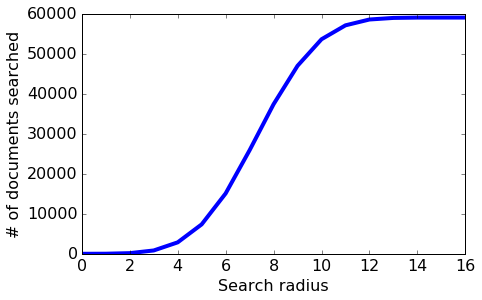

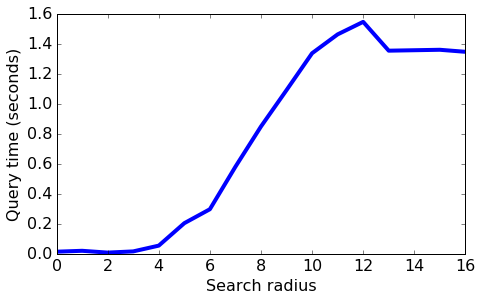

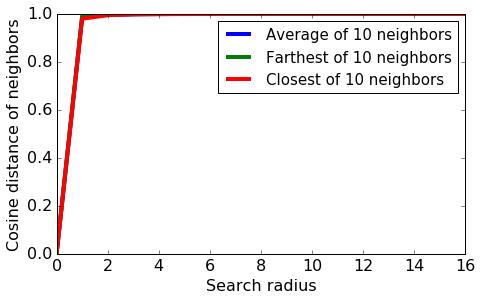

In [47]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:
* As we increase the search radius, we find more neighbors that are a smaller distance away.
* With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
* With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query

Then we run LSH multiple times with different search radii.

In [48]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame(index = range(num_data_points))
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance', ascending=False)[:k]

The following cell will run LSH with multiple search radii and compute the quality metrics for each run. Allow a few minutes to complete.

In [49]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(vect.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(vect[ix,:], vect, k=25).index.values)
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(vect[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result.index.values) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


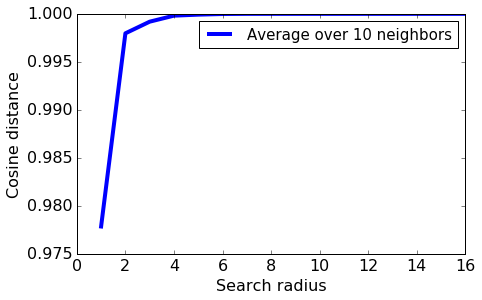

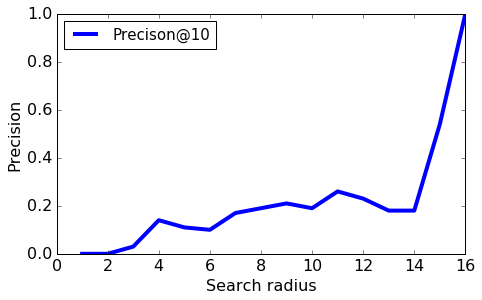

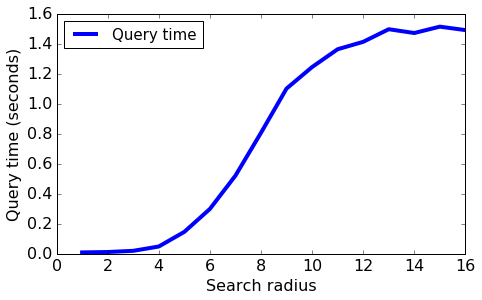

In [50]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

The observations for Timberlake generalize to the entire dataset.

## Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

Allow a few minutes for the following cell to complete.

In [51]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(vect.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(vect[ix,:], vect, k=25).index.values)
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(vect, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(vect[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result.index.values) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


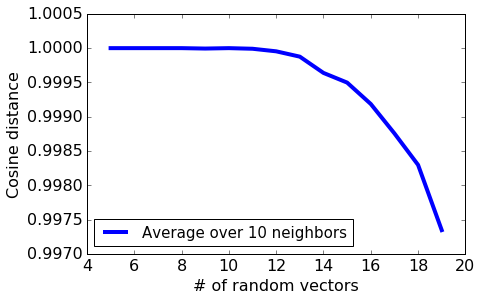

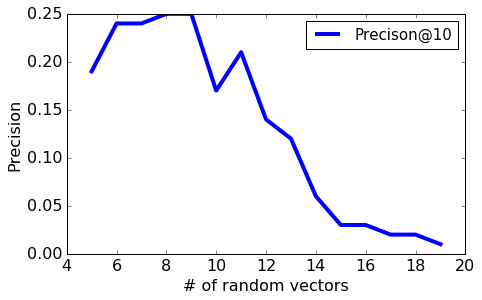

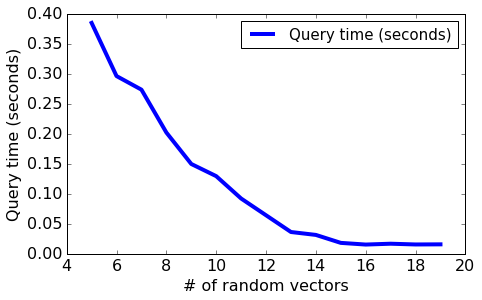

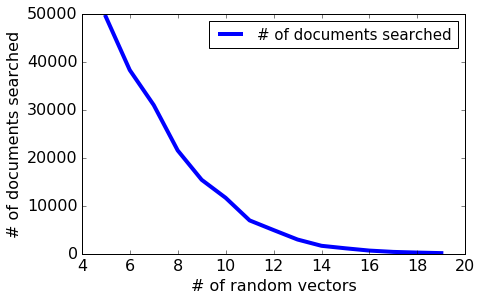

In [52]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.